In [1]:
# Base Data Science snippet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm_notebook
from scipy.spatial.distance import cdist
import imageio
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.animation as animation

plt.style.use("seaborn-dark")

import sys
sys.path.append("../")
from rl.agents.q_agent import QAgent

Initialized Delivery Environment with 26 random stops


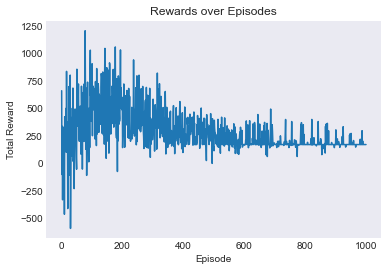

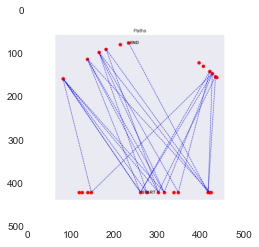

In [2]:


# Helper function to calculate the angle between two points
def angle_between_points(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    angle_rad = np.arctan2(y2 - y1, x2 - x1)
    return np.degrees(angle_rad)

class Environment(object):
    def __init__(self, n_stops=8):
        print(f"Initialized Delivery Environment with {n_stops} random stops")

        # Initialization
        self.n_stops = n_stops
        self.action_space = self.n_stops
        self.observation_space = self.n_stops
        self.stops = []

        # Generate Stops
        self._generate_stops()
        self._generate_q_values()
        self.reset()

    def _generate_stops(self):
        xy = np.loadtxt('test2.csv', delimiter=",")
        self.x = xy[:, 0]
        self.y = xy[:, 1]

    def _generate_q_values(self):
        xy = np.column_stack([self.x, self.y])
        mat = np.zeros((len(xy), len(xy)))

        for i in range(len(xy)):
            for j in range(len(xy)):
                if (xy[j][1] - xy[i][1]) == 0:
                    mat[i][j] = -100
                elif (xy[j][1] != 0) and (xy[i][1] != 0):
                    mat[i][j] = -100
                else:
                    # Calculate the angle between the points
                    angle = angle_between_points(xy[i], xy[j])
                    mat[i][j] = angle

        self.q_stops = mat

    def render(self, return_img=False):
        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(111)
        ax.set_title("Paths")

        # Show stops
        ax.scatter(self.x, self.y, c="red", s=50)

        # Show START
        if len(self.stops) > 0:
            xy = self._get_xy(initial=True)
            xytext = xy[0] + 0.1, xy[1] - 0.05
            ax.annotate("START", xy=xy, xytext=xytext, weight="bold")

        # Show itinerary
        if len(self.stops) > 1:
            ax.plot(self.x[self.stops], self.y[self.stops], c="blue", linewidth=1, linestyle="--")

            # Annotate END
            xy = self._get_xy(initial=False)
            xytext = xy[0] + 0.1, xy[1] - 0.05
            ax.annotate("END", xy=xy, xytext=xytext, weight="bold")

        plt.xticks([])
        plt.yticks([])

        if return_img:
            # From https://ndres.me/post/matplotlib-animated-gifs-easily/
            fig.canvas.draw_idle()
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            plt.close()
            return image
        else:
            plt.show()

    def reset(self):
        # Stops placeholder
        self.stops = [0]
        # Random first stop
        return self.stops[-1]

    def step(self, destination):
        # Get current state
        state = self._get_state()
        new_state = destination

        # If attempting to traverse a large negative value transition, reset the new_state to the current state
        if self.q_stops[state, new_state] == -100:
            new_state = state

        # Get reward for such a move
        reward = self.q_stops[state, new_state]

        # Append new_state to stops
        self.stops.append(destination)
        done = len(self.stops) == self.n_stops

        return new_state, reward, done

    def _get_state(self):
        return self.stops[-1]

    def _get_xy(self, initial=False):
        state = self.stops[0] if initial else self._get_state()
        x = self.x[state]
        y = self.y[state]
        return x, y


class DeliveryQAgent:
    def __init__(self, states_size, actions_size, epsilon=1.0, epsilon_decay=0.995, gamma=0.99, lr=0.1):
        self.states_size = states_size
        self.actions_size = actions_size
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.lr = lr
        self.Q = np.zeros((states_size, actions_size))
        self.states_memory = []

    def act(self, s):
        # Get Q Vector
        q = np.copy(self.Q[s, :])

        # Avoid already visited states
        q[self.states_memory] = -np.inf

        # Filter out invalid actions (path from non-zero y to non-zero y and from x-axis to x-axis)
        valid_actions = [a for a in range(self.actions_size) if (env.y[a] == 0 and env.y[s] != 0) or (env.y[a] != 0 and env.y[s] == 0)]

        if np.random.rand() > self.epsilon:
            # Choose the action with the highest Q-value among valid actions
            valid_q = q[valid_actions]
            a = valid_actions[np.argmax(valid_q)]
        else:
            # Choose a random valid action
            a = np.random.choice(valid_actions)

        return a

    def remember_state(self, s):
        self.states_memory.append(s)

    def reset_memory(self):
        self.states_memory = []

    def train(self, state, action, reward, next_state):
        # Q-learning update rule
        max_next_q = np.max(self.Q[next_state, :])
        self.Q[state, action] = self.Q[state, action] + self.lr * (reward + self.gamma * max_next_q - self.Q[state, action])

    def decay_epsilon(self):
        self.epsilon *= self.epsilon_decay


# Main function to run the Q-learning algorithm
def run_q_learning(env, agent, n_episodes=1000, render_each=5, fps=10):
    rewards = []
    imgs = []

    for i in range(n_episodes):
        s = env.reset()
        agent.reset_memory()
        episode_reward = 0.

        while True:
            # Remember the state
            agent.remember_state(s)

            # Choose an action
            a = agent.act(s)

            # Take the action, and get the reward from the environment
            s_next, r, done = env.step(a)

            # Update Q-table
            agent.train(s, a, r, s_next)

            # Update the caches
            episode_reward += r
            s = s_next

            # If the episode is terminated
            if done:
                break

        rewards.append(episode_reward)

        # Decay epsilon
        agent.decay_epsilon()

        # Render the environment every few episodes
        if i % render_each == 0:
            img = env.render(return_img=True)
            imgs.append(img)

    return rewards, imgs


if __name__ == "__main__":
    # Correct Reward Path For Light
    env = Environment(n_stops=26)
    agent = DeliveryQAgent(states_size=env.observation_space, actions_size=env.action_space)
    rewards, imgs = run_q_learning(env, agent)
    
    # Visualize the rewards
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Rewards over Episodes")
    plt.show()


    # Create a function to update the plot for each frame of the animation
    def update(frame):
        img.set_array(imgs[frame])
        return img,

    # Create the animation figure and axis
    fig, ax = plt.subplots()

    # Create the initial plot
    img = ax.imshow(imgs[0])

    # Set up the animation
    ani = animation.FuncAnimation(fig, update, frames=len(imgs), interval=200, blit=True)

    # Display the animation
    plt.show()


In [3]:
env.q_stops

array([[-100.        ,   45.        , -100.        ,   34.15936042,
        -100.        ,  100.06285475, -100.        ,  146.5743481 ,
        -100.        ,  123.40994611, -100.        ,   38.10550765,
        -100.        ,   36.59687447, -100.        ,  118.13436423,
        -100.        ,  146.642102  , -100.        ,  106.81618834,
        -100.        ,   34.75112092, -100.        ,   42.10141666,
        -100.        ,  131.51894201],
       [-135.        , -100.        ,  -80.78801004, -100.        ,
        -109.29565433, -100.        , -151.52155743, -100.        ,
        -154.01991782, -100.        , -124.68245412, -100.        ,
         -78.04742551, -100.        , -120.68403339, -100.        ,
        -153.47370903, -100.        , -152.27587603, -100.        ,
        -113.21194632, -100.        ,  -79.38331156, -100.        ,
        -131.64704488, -100.        ],
       [-100.        ,   99.21198996, -100.        ,   80.78801004,
        -100.        ,  139.81504747, 

In [4]:
def run_corr_episode(env,agent,verbose = 1):

    s = env.reset()
    agent.reset_memory()
    arr = [0, 1, 2, 3, 4, 5, 6]

    episode_reward = 0

    for i in arr:
                  
        # Remember the states
        agent.remember_state(s)
        
        # Take the action, and get the reward from environment
        s_next,r,done = env.step(i)

        # Tweak the reward
        r = r

        if verbose: print(s_next,r,done)

        # Update our knowledge ein the Q-table
        agent.train(s,i,r,s_next)

        # Update the caches
        episode_reward += r
        s = s_next

        # If the episode is terminated
        if done:
            break
            
    return env,agent,episode_reward


In [5]:
#Correct Reward Path For Light
env = Environment(n_stops = 8,method = "angle_difference" )
agent = DeliveryQAgent(env,env.observation_space,env.action_space)
env, agent, reward = run_corr_episode(env,agent)
print("Iteration Reward = ", reward)
env.render()

TypeError: __init__() got an unexpected keyword argument 'method'

In [ ]:
def grid_search_hyperparameters(env, hyperparameter_grid, n_episodes=1000, render_each=10, fps=10):
    best_hyperparameters = None
    best_mean_reward = float("-inf")
    rewards_by_hyperparameters = {}

    # Loop through all possible combinations of hyperparameters
    for hyperparameters in hyperparameter_grid:
        print(f"Training with hyperparameters: {hyperparameters}")

        # Create the agent with the current set of hyperparameters
        agent = DeliveryQAgent(env,states_size=env.observation_space, actions_size=env.action_space, 
                               epsilon=hyperparameters['epsilon'],
                               epsilon_decay=hyperparameters['epsilon_decay'],
                               gamma=hyperparameters['gamma'],
                               lr=hyperparameters['lr'])

        # Train the agent and get rewards
        _, _, rewards = run_n_episodes(env, agent, n_episodes=n_episodes, render_each=render_each, fps=fps)
        rewards_by_hyperparameters[str(hyperparameters)] = rewards

        # Calculate the mean reward over the last episodes
        mean_reward = np.mean(rewards[-100:])
        print(f"Mean reward over the last 100 episodes: {mean_reward}")

        # Check if it's the best set of hyperparameters so far
        if mean_reward > best_mean_reward:
            best_mean_reward = mean_reward
            best_hyperparameters = hyperparameters

    print("Grid search complete.")
    print("Best Hyperparameters:")
    print(best_hyperparameters)

    return best_hyperparameters, rewards_by_hyperparameters


if __name__ == "__main__":
    # Define the hyperparameter grid with the range of values to search through
    hyperparameter_grid = [
        {"epsilon": 0.2, "epsilon_decay": 0.8, "gamma": 0.7, "lr": 0.1},
        {"epsilon": 0.4, "epsilon_decay": 0.9, "gamma": 0.8, "lr": 0.3},
        {"epsilon": 0.6, "epsilon_decay": 0.95, "gamma": 0.9, "lr": 0.5},
        {"epsilon": 0.8, "epsilon_decay": 0.95, "gamma": 0.9, "lr": 0.7}
    ]

    # Create the environment
    env = Environment(n_stops=8)

    # Perform grid search hyperparameter tuning
    best_hyperparameters, rewards_by_hyperparameters = grid_search_hyperparameters(env, hyperparameter_grid)

    # Train the final agent with the best hyperparameters
    agent = DeliveryQAgent(env,states_size=env.observation_space, actions_size=env.action_space, 
                           epsilon=best_hyperparameters['epsilon'],
                           epsilon_decay=best_hyperparameters['epsilon_decay'],
                           gamma=best_hyperparameters['gamma'],
                           lr=best_hyperparameters['lr'])
    p, q, r = run_n_episodes(env, agent, n_episodes=1000, render_each=10, fps=10)


In [ ]:
result = r[-100:]==reward
count_true = np.count_nonzero(result)
print("Iterations matching optimal reward = ", count_true)

In [ ]:
from IPython.display import Image
Image(filename="training.gif")